# Linear Regression and KNN Regression on Insurance Dataset

This notebook implements Linear Regression and KNN Regression models to predict healthcare insurance charges based on features like age, BMI, smoking status, etc.

## Import Libraries

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

## Load Data

In [9]:
df = pd.read_csv('insurance.csv')
print("First 5 rows:")
print(df.head())
print("\nData info:")
print(df.info())

First 5 rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


## Data Exploration

Statistical summary:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


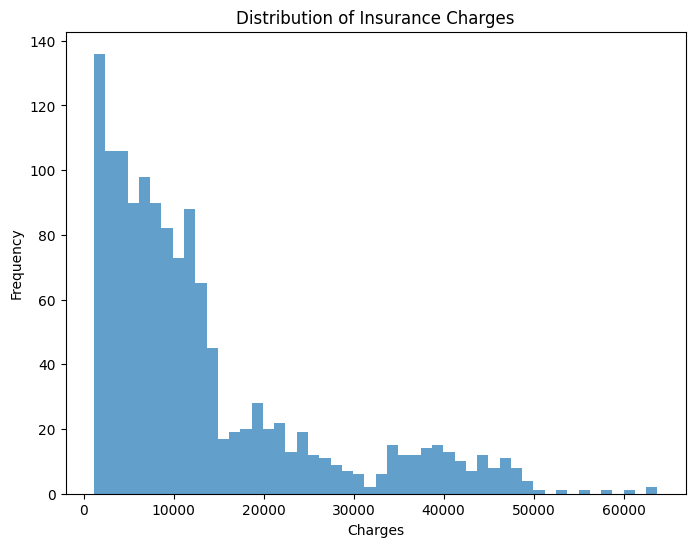

In [10]:
print("Statistical summary:")
print(df.describe())

# Visualize charges distribution
plt.figure(figsize=(8,6))
plt.hist(df['charges'], bins=50, alpha=0.7)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

## Preprocessing

In [11]:
# Encode categorical variables
categorical_cols = ['sex', 'smoker', 'region']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Features and target
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'bmi', 'children']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1070, 8)
Test set shape: (268, 8)


## Linear Regression

In [12]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr:.2f}")
print(f"Linear Regression R²: {r2_lr:.2f}")

Linear Regression MSE: 33596915.85
Linear Regression R²: 0.78


## KNN Regression

In [13]:
# Train KNN Regression
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluate
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Regression MSE: {mse_knn:.2f}")
print(f"KNN Regression R²: {r2_knn:.2f}")

KNN Regression MSE: 46285808.78
KNN Regression R²: 0.70


## Comparison

Model Comparison:
Linear Regression - MSE: 33596915.85, R²: 0.78
KNN Regression - MSE: 46285808.78, R²: 0.70


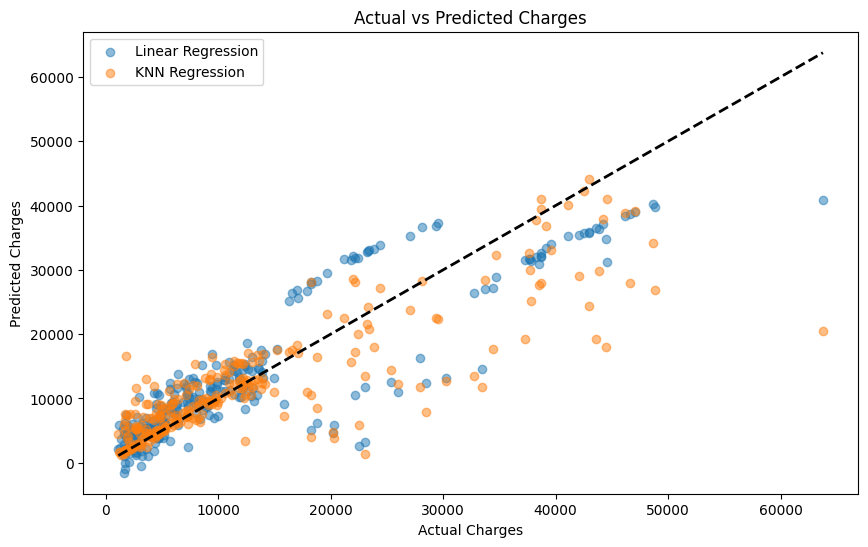

In [14]:
# Compare models
print("Model Comparison:")
print(f"Linear Regression - MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")
print(f"KNN Regression - MSE: {mse_knn:.2f}, R²: {r2_knn:.2f}")

# Plot predictions
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, y_pred_knn, alpha=0.5, label='KNN Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.legend()
plt.show()